# MSCA ML Final Project: Face-to-BMI
# Part 2: Image Embedding and Basic VGG

Deliverables:

1-You must create a simple web API to predict a user's BMI in real-time. You can also use webcam input. The goal is to use one of the pre-trained image models (e.g. VGG Face), fine-tune with the provided data, and deploy via jupyter notebook, streamlit, flask or any other simple restful api's.

2-10 pages of the write-up about your implementation.

3-10 mins presentation or live demo in the final lecture.

Our goal is to beat the performance metrics provided in the paper.

## Set-up

In [1]:
''' # colab mount
import os
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')
path_gdrive = '/content/drive/MyDrive/Colab Datasets/ML/BMI'
os.chdir(path_gdrive)
print(os.getcwd())'''

" # colab mount\nimport os\n# Load the Drive helper and mount\nfrom google.colab import drive\n\n# This will prompt for authorization.\ndrive.mount('/content/drive/')\npath_gdrive = '/content/drive/MyDrive/Colab Datasets/ML/BMI'\nos.chdir(path_gdrive)\nprint(os.getcwd())"

In [2]:
import os

# Google Bucket
bucket_path = 'gs://msca-sp23-bucket/ml_data'
file = 'BMI-20230313T174553Z-001.zip'
runtime_path = '/home/jupyter/data/ml/BMI'

os.chdir(runtime_path)
print(os.getcwd())

/home/jupyter/data/ml/BMI


In [3]:
import sys
import os
import pandas as pd
import numpy as np

import re
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [5]:
# read csv file
bmi = pd.read_csv(runtime_path + '/all_data.csv')
bmi.head(2)

,bmi,gender,is_training,name,imgae_type,id,path
0,34.207396,Male,1,img_0.bmp,bmp,0,/home/jupyter/data/ml/BMI/Images/img_0.bmp
1,26.453720,Male,1,img_1.bmp,bmp,1,/home/jupyter/data/ml/BMI/Images/img_1.bmp


In [6]:
import tensorflow as tf
from tensorflow import keras

2023-05-16 06:32:15.392050: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 06:32:15.455387: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 06:32:15.456863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 06:32:16.428533: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.12.0
Keras version: 2.12.0


In [8]:
#!pip install keras_vggface

### Prepare Keras

In [9]:
# !python --version

In [10]:
# # @https://stackoverflow.com/questions/68862735/keras-vggface-no-module-named-keras-engine-topology
#! pip install git+https://github.com/rcmalli/keras-vggface.git
#! pip install keras_applications --no-deps

In [11]:
# filename = "/opt/conda/envs/nlp/lib/python3.10/site-packages/keras_vggface/models.py"
# text = open(filename).read()
# open(filename, "w+").write(text.replace('keras.engine.topology', 'keras.utils.layer_utils'))

## Helper Functions

In [12]:
# ! pip install opencv-python
# ! pip install mtcnn

In [13]:
# keras vggface model
import tensorflow as tf
from keras.layers import Flatten, Dense, Input, Dropout, Activation, BatchNormalization

from keras_vggface.vggface import VGGFace
from keras.models import Model
# example of loading an image with the Keras API
# since 2021 tensorflow updated the package and moved model directory
from tensorflow.keras.preprocessing import image
import keras_vggface.utils as utils

# image manipulation
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2

# face alignment
from mtcnn.mtcnn import MTCNN

# model metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# common packages
import os
import numpy as np
import pandas as pd

In [14]:
# easy-to-use metrics
def rmse(x,y):
    return np.sqrt(mean_squared_error(x,y))

def mae(x,y):
    return mean_absolute_error(x,y)

def auc(label, pred):
    return roc_auc_score(label, pred)

# image feature extraction
# def imgs_to_array(img_paths, version=1):
#     ''' extract features from all images and convert to multi-dimensional array
#     Takes:
#         img_path: str
#         version: int
#     Returns:
#         np.array
#     '''
#     imgs = []
#     for img_path in img_paths: # += is equivalent to extend @http://noahsnail.com/2020/06/17/2020-06-17-python%E4%B8%ADlist%E7%9A%84append,%20extend%E5%8C%BA%E5%88%AB/
#         imgs += [img_to_array(img_path, version)]
#     return np.concatenate(imgs)

def imgs_to_array(img_paths, version=1):
    ''' extract features from all images and convert to multi-dimensional array
    Takes:
        img_path: str
        version: int
    Returns:
        np.array
    '''
    imgs = []
    for img_path in img_paths: # += is equivalent to extend @http://noahsnail.com/2020/06/17/2020-06-17-python%E4%B8%ADlist%E7%9A%84append,%20extend%E5%8C%BA%E5%88%AB/
        imgs += [img_to_array(img_path, version)]
    return np.concatenate(imgs)

def process_array(arr, version):
    '''array processing (resize)
    Takes: arr: np.array
    Returns: np.array
    '''
    img = cv2.resize(arr, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = utils.preprocess_input(img, version=version)
    return img

def img_to_array(img_path, version):
    '''conver a SINGLE image to array
    Takes: img_path: str
    Returns: np.array
    '''
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    img = process_array(img, version)
    return img

def crop_img(img,x,y,w,h):
    '''crop image
    Takes: img: np.array
           x,y,w,h: int
    Returns: np.array
    '''
    return img[y:y+h,x:x+w,:]

def img_data_generator(data, bs, img_dir, train_mode=True, version = 1): #replace function name later
    """data input pipeline
    Takes:
        data: pd.DataFrame
        bs: batch size
        img_dir: str, directory to the images
        train_mode: bool, if False, take samples from test set to aoivd overfitting
        version: int, keras_vggface version
    Returns:
        features: tuple of (x,y): features and targets
    """
    sex_map = {'Male':1, 'Female':0}
    loop = True
     
    while loop:
        if train_mode:
            x = imgs_to_array(data['path'], version)
            y = [data['bmi'].values, data['gender'].map(lambda i: sex_map.get(i,0)).values]
            features = (x,y)
        else:
            if len(data) >= bs:
                sampled = data.iloc[:bs,:]
                data = data.iloc[bs:,:]
                features = imgs_to_array(sampled['index'],img_dir, version)
            else: 
                loop = False
        yield features

In [15]:
# Build a prediction class

class FacePrediction(object):

    def __init__(self, img_dir, model_type='vgg16', sex_thresh = 0.05):
        self.model_type = model_type
        self.img_dir = img_dir
        self.detector = MTCNN()
        self.sex_thres = sex_thresh
        if model_type in ['vgg16', 'vgg16_fc6']: # we might use other models, but in that case we need to just version input
            self.version = 1
        else:
            self.version = 2

    def define_model(self, hidden_dim = 64, drop_rate=0.0, freeze_backbone = True): # replace function name later
        ''' initialize the vgg model
        Reference:
            @https://zhuanlan.zhihu.com/p/53116610
            @https://zhuanlan.zhihu.com/p/26934085
        '''
        if self.model_type == 'vgg16_fc6':
            vgg_model = VGGFace(model = 'vgg16', include_top=True, input_shape=(224, 224, 3))
            last_layer = vgg_model.get_layer('fc6').output
            flatten = Activation('relu')(last_layer)
        else:
            vgg_model = VGGFace(model = self.model_type, include_top=False, input_shape=(224, 224, 3))
            last_layer = vgg_model.output
            flatten = Flatten()(last_layer)
        
        if freeze_backbone: # free the vgg layers to fine-tune
            for layer in vgg_model.layers:
                layer.trainable = False
                
        def model_init(flatten, name):
            x = Dense(hidden_dim, name=name + '_fc1')(flatten)
            x = BatchNormalization(name = name + '_bn1')(x)
            x = Activation('relu', name = name+'_act1')(x)
            x = Dropout(drop_rate)(x)
            #x = Dense(hidden_dim, name=name + '_fc2')(x)
            #x = BatchNormalization(name = name + '_bn2')(x)
            #x = Activation('relu', name = name+'_act2')(x)
            #x = Dropout(drop_rate)(x)
            return x
        
        x = model_init(flatten, name = 'bmi')
        bmi_pred = Dense(1, activation='linear', name='bmi')(x)
        
        x = model_init(flatten, name = 'sex')
        sex_pred = Dense(1, activation = 'sigmoid', name = 'sex')(x)

        custom_vgg_model = Model(vgg_model.input, [bmi_pred, sex_pred])
        custom_vgg_model.compile('adam', 
                                 {'bmi':'mae', 'sex':'binary_crossentropy'},
                                 {'sex': 'accuracy'}, 
                                 loss_weights={'bmi': 0.8, 'sex':0.2})

        self.model = custom_vgg_model

    def train(self, train_data, val_data, bs, epochs, callbacks):
        ''' train the model
        Notes: 1/ we already have labeled images for training, so we won't need to consider epochs and batch_size
        Takes: 
            train_data: dataframe
            val_data: dataframe
            bs: int, batch size
            epochs: int, number of epochs
            callbacks: list, callbacks
        Recall the input for img_data_generator: data, bs, img_dir, train_mode=True, version = 1
        '''
        train_gen = img_data_generator(train_data, bs, self.img_dir, True, self.version)
        val_gen = img_data_generator(val_data, bs, self.img_dir, True, self.version)
        self.model.fit_generator(train_gen, len(train_data)//bs, epochs=epochs,
                                 validation_data=val_gen, validation_steps=len(val_data)//bs,
                                 callbacks=callbacks)
    
    def evaluate_perf(self, val_data):
        img_paths = val_data['path'].values
        arr = imgs_to_array(img_paths, self.version)
        bmi, sex = self.model.predict(arr)
        metrics = {'bmi_mae':mae(bmi[:,0], val_data.bmi.values), 
                   'sex_auc':auc(val_data.gender, sex[:,0])}
        return metrics
    
    def detect_faces(self, img_path, confidence):
        img = image.load_img(img_path)
        img = image.img_to_array(img)
        box = self.detector.detect_faces(img)
        box = [i for i in box if i['confidence'] > confidence]
        res = [crop_img(img, *i['box']) for i in box]
        res = [process_array(i, self.version) for i in res]
        return box, res
    
    # def predict(self, img_dir, show_img = False):
    #     if os.path.isdir(img_dir): # check if this is a directory
    #         imgs = os.listdir(img_dir)
    #         # use os to get all the paths of images in the directory
    #         imgs_paths = [os.path.join(img_dir, i) for i in os.listdir(img_dir)]
    #         arr = imgs_to_array(imgs_paths, self.version)
    #     else:
    #         img_path = img_dir
    #         arr = img_to_array(img_path, self.version)
    #     preds = self.model.predict(arr)
        
    #     if show_img and os.path.isdir(img_dir):
    #         bmi, sex = preds
    #         num_plots = len(imgs)
    #         ncols = 5
    #         nrows = int((num_plots - 0.1) // ncols + 1)
    #         fig, axs = plt.subplots(nrows, ncols)
    #         fig.set_size_inches(3 * ncols, 3 * nrows)
    #         for i, img in enumerate(imgs):
    #             col = i % ncols
    #             row = i // ncols
    #             axs[row, col].imshow(plt.imread(os.path.join(img_dir, img)))
    #             axs[row, col].axis('off')
    #             axs[row, col].set_title('BMI: {:3.1f} SEX: {:2.1f}'.format(bmi[i,0], sex[i,0]), fontsize = 12)
        
    #     return preds

    def predict(self, img_dir, show_img = False):
        if os.path.isdir(img_dir): # check if this is a directory
            imgs = os.listdir(img_dir)
            # use os to get all the paths of images in the directory
            imgs_paths = [os.path.join(img_dir, i) for i in os.listdir(img_dir)]
            arr = imgs_to_array(imgs_paths, self.version)
        else:
            img_path = img_dir
            arr = img_to_array(img_path, self.version)
        preds = self.model.predict(arr)
        
        if show_img and os.path.isdir(img_dir):
            bmi, sex = preds
            num_plots = len(imgs)
            ncols = 5
            nrows = int((num_plots - 0.1) // ncols + 1)
            fig, axs = plt.subplots(nrows, ncols)
            fig.set_size_inches(3 * ncols, 3 * nrows)
            for i, img in enumerate(imgs):
                col = i % ncols
                row = i // ncols
                axs[row, col].imshow(plt.imread(os.path.join(img_dir,img)))
                axs[row, col].axis('off')
                axs[row, col].set_title('BMI: {:3.1f} SEX: {:2.1f}'.format(bmi[i,0], sex[i,0]), fontsize = 10)
             
        return preds


    def predict_df(self, img_dir):
        assert os.path.isdir(img_dir), 'input must be directory'
        fnames = os.listdir(img_dir)
        bmi, sex = self.predict(img_dir)
        results = pd.DataFrame({'img':fnames, 'bmi':bmi[:,0], 'sex':sex[:,0]})
        results['sex_prob'] = results['sex']
        results['sex'] = results['sex'].map(lambda i: 'Male' if i > self.sex_thresh else 'Female')
        return results
    
    def save_weights(self, model_dir):
        self.model.save_weights(model_dir)
        
    def load_weights(self, model_dir):
        self.model.load_weights(model_dir)

    def predict_faces(self, img_path, show_img = True, color = "white", fontsize = 12, 
                      confidence = 0.95, fig_size = (16,12)):
        
        assert os.path.isfile(img_path), 'only single image is supported'
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        boxes, faces = self.detect_faces(img_path, confidence)
        preds = [self.model.predict(face) for face in faces]
        
        if show_img:
            # Create figure and axes
            num_box = len(boxes)
            fig,ax = plt.subplots()
            fig.set_size_inches(fig_size)
            # Display the image
            ax.imshow(img)
            ax.axis('off')
            # Create a Rectangle patch
            for idx, box in enumerate(boxes):
                bmi, age, sex = preds[idx]
                box_x, box_y, box_w, box_h = box['box']
                rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1,edgecolor='yellow',facecolor='none')
                ax.add_patch(rect)
                ax.text(box_x, box_y, 
                        'BMI:{:3.1f}\nSEX:{:s}'.format(bmi[0,0], age[0,0], 'M' if sex[0,0] > self.sex_thresh else 'F'),
                       color = color, fontsize = fontsize)
            plt.show()

        return preds

## Training

### Data split

In [16]:
df = bmi[['bmi', 'gender', 'is_training', 'path', 'name']].sample(100)
df.head()

,bmi,gender,is_training,path,name
2213,30.068167,Male,1,/home/jupyter/data/ml/BMI/Images/img_2305.bmp,img_2305.bmp
543,22.140338,Female,1,/home/jupyter/data/ml/BMI/Images/img_559.bmp,img_559.bmp
1956,25.839831,Female,1,/home/jupyter/data/ml/BMI/Images/img_2026.bmp,img_2026.bmp
3310,22.273026,Male,0,/home/jupyter/data/ml/BMI/Images/img_3481.bmp,img_3481.bmp
1355,24.658895,Female,1,/home/jupyter/data/ml/BMI/Images/img_1397.bmp,img_1397.bmp


In [17]:
# set configs
all_images_path = os.listdir('/home/jupyter/data/ml/BMI/')

# split train, test; note that test set is not used for traning
train_set = df[df.is_training==1]
test_set = df[df.is_training==0] 

# train, validation split
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_set, test_size=0.2, random_state=42)

### Model

In [18]:
mode = 'train' #'train' or 'predict'
model_type = 'vgg16'
model_tag = 'base'
model_id = '{:s}_{:s}'.format(model_type, model_tag)
model_dir = '/home/anthony/projects/dl_image_bmi/saved_models/saved_model_{:s}.h5'.format(model_id)
bs = 8
epochs = 2
freeze_backbone = True # True => transfer learning; False => train from scratch

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
es = EarlyStopping(patience=3)
ckp = ModelCheckpoint(model_dir, save_best_only=True, save_weights_only=True, verbose=1)
tb = TensorBoard('./tb/%s'%(model_id))
callbacks = [es, ckp]

In [20]:
%%time

model = FacePrediction(img_dir = all_images_path, model_type = model_type)
model.define_model(freeze_backbone = freeze_backbone)
model.model.summary()
if mode == 'train':
    model_history = model.train(train, valid, bs = bs, epochs = epochs, callbacks = callbacks)
else:
    model.load_weights(model_dir)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[0][0]']                
                                )                                                           

/var/tmp/ipykernel_2917/3313542336.py:72: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(train_gen, len(train_data)//bs, epochs=epochs,


Epoch 1/2


2023-05-16 06:32:20.564637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - ETA: 0s - loss: 27.0827 - bmi_loss: 33.8205 - sex_loss: 0.1314 - sex_accuracy: 0.9251

2023-05-16 06:32:47.800117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 24.61783, saving model to /home/anthony/projects/dl_image_bmi/saved_models/saved_model_vgg16_base.h5
7/7 [==============================] - 30s 4s/step - loss: 27.0827 - bmi_loss: 33.8205 - sex_loss: 0.1314 - sex_accuracy: 0.9251 - val_loss: 24.6178 - val_bmi_loss: 30.6200 - val_sex_loss: 0.6090 - val_sex_accuracy: 0.8125
Epoch 2/2
7/7 [==============================] - ETA: 0s - loss: 26.2965 - bmi_loss: 32.8668 - sex_loss: 0.0152 - sex_accuracy: 1.0000
Epoch 2: val_loss improved from 24.61783 to 23.51244, saving model to /home/anthony/projects/dl_image_bmi/saved_models/saved_model_vgg16_base.h5
7/7 [==============================] - 28s 4s/step - loss: 26.2965 - bmi_loss: 32.8668 - sex_loss: 0.0152 - sex_accuracy: 1.0000 - val_loss: 23.5124 - val_bmi_loss: 29.2967 - val_sex_loss: 0.3755 - val_sex_accuracy: 0.8125
CPU times: user 13min 45s, sys: 28.6 s, total: 14min 14s
Wall time: 59.1 s


## Evaluations

In [21]:
valid['gender_label'] = valid.gender.map(lambda i: 1 if i == 'Male' else 0)

In [22]:
import json
import glob

metrics = model.evaluate_perf(valid)
metrics['model'] = model_type
with open('/home/anthony/projects/dl_image_bmi/metrics/{:s}.json'.format(model_type), 'w') as f:
    json.dump(metrics, f)

metrics = []
for i in glob.glob('/home/anthony/projects/dl_image_bmi/metrics/*.json'):
    with open(i, 'r') as f:
        res = json.load(f)
    metrics.append(res)
metrics = pd.DataFrame(metrics)
metrics['model'] = metrics['model'].apply(lambda i: '* ' + i if i == model_id else i)
metrics.set_index('model').round(3)

1/1 [==============================] - 1s 1s/step


,bmi_mae,sex_auc
model,,
vgg16,29.297,1.0


## Prediction

In [23]:
single_test_img = '/home/jupyter/data/ml/BMI/Images/img_1001.bmp'
model.predict(single_test_img)

1/1 [==============================] - 0s 91ms/step


[array([[-0.6997892]], dtype=float32), array([[0.9377321]], dtype=float32)]

1/1 [==============================] - 0s 495ms/step


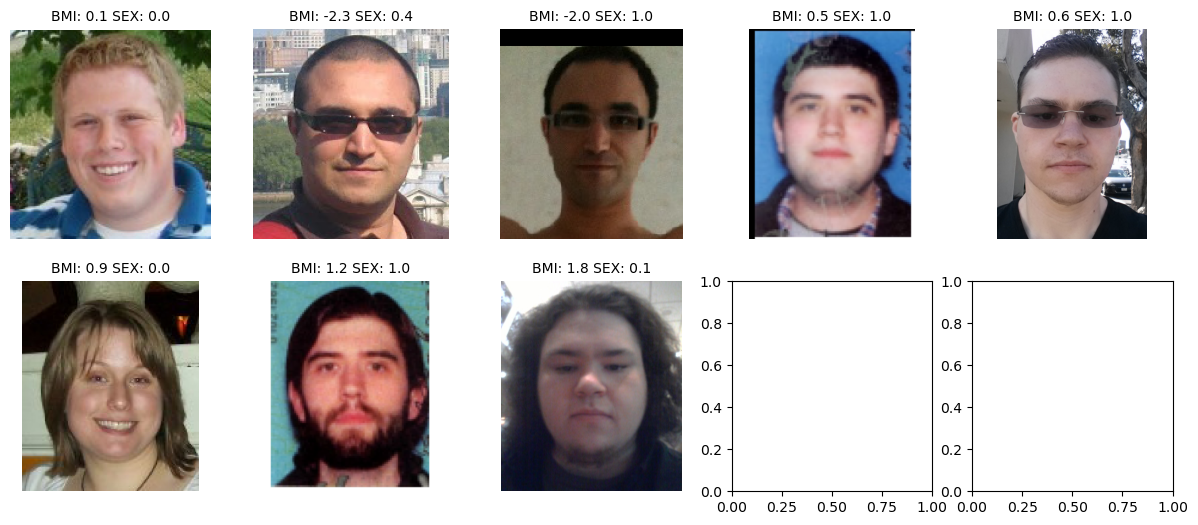

In [24]:
mutiple_test_imgs = '/home/jupyter/data/ml/BMI/Extra_test_images'

preds = model.predict(mutiple_test_imgs, show_img=True)

Note:

1. Transfer Learning. https://medium.com/@leosimmons/estimating-body-mass-index-from-face-images-using-keras-and-transfer-learning-de25e1bc0212